**Initial Model for Relevance Classification**

Module References

In [ ]:
import pandas as pd
import nltk
import pandas as pd
import numpy as np
import re
import math
import random
import matplotlib.pyplot as plt 
import seaborn as sns
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier as XGBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, auc, roc_auc_score, roc_curve
from matplotlib import pyplot
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


Load Raw Data with Sample

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/A3/RawDataWithSample.xlsx")

In [ ]:
df['SampleResponse'].value_counts()

X    364
N    113
R    103
M     20
Name: SampleResponse, dtype: int64

Functions for Cleaning Data, for running models and crossvalidation

In [ ]:
import time
#removes an element by regex
def remove_by_regex(texts, regexp):
        output_texts = regexp.sub("",texts)
        return output_texts
#removes urls   
def remove_urls(input_text):
        return remove_by_regex(input_text, re.compile(r"http.?://[^\s]+[\s]?"))

#preprocessing of data
def preprocesstext(incorpus):
    outcorpus = []
    for i in range(0, len(incorpus)):
      corpuselement = remove_urls(incorpus[i])
      corpuselement = re.sub('[^a-zA-Z]', ' ', corpuselement)
      corpuselement = corpuselement.lower()
      corpuselement = corpuselement.split()
      ps = PorterStemmer()
      all_stopwords = stopwords.words('english')
      corpuselement = [ps.stem(word) for word in corpuselement 
                       if not word in set(all_stopwords)]
      corpuselement = ' '.join(corpuselement)
      outcorpus.append(corpuselement)
    return outcorpus
    
# plot the precision-recall curves
def plot_precision_recall(y_test,m_recall,m_precision,classifier_name):
    no_model = len(y_test[y_test==1]) / len(y_test)
    pyplot.plot([0, 1], [no_model, no_model], linestyle='--', label='No Model')
    pyplot.plot(m_recall, m_precision, marker='.', label=str(classifier_name))
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

def plot_roc_auc(y_test,probs, classifier):
    nm_probs = [0 for _ in range(len(y_test))]
    # calculate scores
    nm_auc = roc_auc_score(y_test, nm_probs)
    m_auc = roc_auc_score(y_test, probs)
    # summarize scores
    print('No Model: ROC AUC=%.3f' % (nm_auc))
    print('{}: ROC AUC={}'.format('classifier_name',m_auc))
    # calculate roc curves
    nm_fpr, nm_tpr, _ = roc_curve(y_test, nm_probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    # plot the roc curve for the model
    pyplot.plot(nm_fpr, nm_tpr, linestyle='--', label='No Model')
    pyplot.plot(fpr, tpr, marker='.', label=str(classifier))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

def run_classifier(X_train, y_train, X_test, y_test, classifier):
    print("")
    print("******Classification ******")
    classifier_name = str(type(classifier).__name__)
    print("Testing " + classifier_name)
    now = time.time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    print("Learing time {0}s".format(time() - now))
    now = time.time()
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    print("Predicting time {0}s".format(time.time() - now))
    # calculate precision and recall for each threshold
    m_precision, m_recall, _ = precision_recall_curve(y_test, probs)
    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    print("************ Results ************")
    print("            Negative    Positive")
    print("F1       " + str(f1))
    print("Precision" + str(precision))
    print("Recall   " + str(recall))
    print("Accuracy " + str(accuracy))
    plot_roc_auc(y_test,probs, classifier_name)
    plot_precision_recall(y_test,m_recall,m_precision,classifier_name)
    return precision, recall, accuracy, f1   

def crossvalidate_classifier(X_train, y_train, classifier, folds):
    #print("")
    #print("******Crossvalidation ******"), 
    classifier_name = str(type(classifier).__name__)
    return cross_validate(classifier, X_train, y_train, cv=folds,
                            scoring=('accuracy', 'f1', 'precision', 'recall', 'roc_auc'), return_train_score=True)

#generates a model classifer and returns predictions
def predictionsforclassifer(X_train, y_train, X_test, classifier):
  model = classifier.fit(X_train, y_train) 
  return model.predict(X_test)

#Generated performance measures for the input classifier
def test_classifier(X_train, y_train, X_test, y_test, classifier):
    print("")
    print("******Classification In Progress ******")
    classifier_name = str(type(classifier).__name__)
    print("Testing " + classifier_name)
    now = time.time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    print("Learning time {0}s".format(time.time() - now))
    now = time.time()
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    print("Predicting time {0}s".format(time.time() - now))
    # calculate precision and recall for each threshold
    m_precision, m_recall, _ = precision_recall_curve(y_test, probs)
    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    print("************Confusion************")
    print(confusion_matrix(y_test, predictions))
    print("************ Results ************")
    print("            Negative    Positive")
    print("F1       " + str(f1))
    print("Precision" + str(precision))
    print("Recall   " + str(recall))
    print("Accuracy " + str(accuracy))
    #plot_roc_auc(y_test,probs, classifier_name)
    #plot_precision_recall(y_test,m_recall,m_precision,classifier_name)
    return precision, recall, accuracy, f1 

def unique_words(x):
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  return len(set(all_words))

def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()

#generates the ISrelevant feature based on samplem input
import math
def IsRelevant(value):
  if isinstance(value, str):
    if value == "X":
      return False
    else:
      return True
  else:
    return np.nan


Clean the data

In [ ]:
df['Processed'] = preprocesstext(df['Content'])

In [ ]:
freq_words(df['Processed'], 10)
unique_words(df['Processed']) #21454

Generate Sample Indices

In [ ]:
import random
random.seed(5552)
numbersamples = 600
sampleindices = random.sample(range(1, df.shape[0]), numbersamples)


In [ ]:
df.SampleResponse.value_counts()

X    364
N    113
R    103
M     20
Name: SampleResponse, dtype: int64

In [ ]:
df['IsRelevant'] = df['SampleResponse'].apply (lambda row: IsRelevant(row))
df['IsSamplePro'] = df['SampleResponse'] == "R"
df['IsSampleAnti'] = df['SampleResponse'] == "M"
df['IsSampleNotRelevant'] = df['SampleResponse'] == "X"

df.info()

In [ ]:
freq_words(df['Processed'][sampleindices][df.IsRelevant==True], 10)
freq_words(df['Processed'][sampleindices][df.IsSamplePro==True], 10)
freq_words(df['Processed'][sampleindices][df.IsSampleAnti==True], 10)

In [ ]:
df.to_excel("/content/drive/MyDrive/A3/PrePRediction2.xlsx")

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/A3/PrePRediction2.xlsx")

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Sample set generated and dimensions inspected

In [ ]:
random.seed(552)
df['IsRelevant'] = df['IsRelevant'].astype('bool')
cvt = TfidfVectorizer(max_features = 1500)
Xpred = cvt.fit_transform(df['Processed'])
Xt = Xpred[sampleindices].toarray()
yt = yt = df['IsRelevant'][sampleindices]
print(Xt.shape)
print(yt.shape)
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size = 0.30, random_state = 552,)
print(Xt_train.shape)
print(yt_train.shape)
print(Xt_test.shape)
print(yt_test.shape)

(600, 1500)
(600,)
(420, 1500)
(420,)
(180, 1500)
(180,)


Model Selection

Random Forest Classifier

In [ ]:
for d in [50, 500, 1000]:
  for e in [50, 500, 1000]:
    print ("d=")
    print(d)
    print ("e=")
    print(e)
    precision, recall, accuracy, f1 = test_classifier(Xt_train, yt_train, Xt_test, yt_test, RandomForestClassifier(max_depth=d, n_estimators = e, random_state=0))


K-Nearest Neighbour

In [ ]:
for n in [1, 2, 3, 5, 10]:
    precision, recall, accuracy, f1 = test_classifier(Xt_train, yt_train, Xt_test, yt_test, KNeighborsClassifier(n_neighbors=3))

Logistic Regression

In [ ]:
precision, recall, accuracy, f1 = test_classifier(Xt_train, yt_train, Xt_test, yt_test, LogisticRegression(random_state=0))

Neural Network

In [ ]:
for a in [1e-5, 1e-4]:
  for hls1 in [2, 5, 10, 20, 40]:
    for hls2 in [2, 3, 5]:
      print('------------------------------------------------')
      print (a)
      print(hls1)
      print(hls2)
      precision, recall, accuracy, f1 = test_classifier(Xt_train, yt_train, Xt_test, yt_test, MLPClassifier(solver='lbfgs', alpha=a, hidden_layer_sizes=(hls1, hls2), random_state=1))


In [ ]:
#test on full sample set
z=predictionsforclassifer(Xt_train, yt_train, Xt, MLPClassifier(solver='lbfgs', alpha=0.00001, hidden_layer_sizes=(30, 2), random_state=1))
cm=confusion_matrix(yt, z)
print(cm)
print((cm[0,0] + cm[1,1])/(cm[0,0]+cm[0,1] + cm[1,0]+cm[1,1]))

[[353  11]
 [  8 228]]
0.9683333333333334


In [ ]:
#train on full sample set, apply to whole set
df['Pred']=predictionsforclassifer(Xt, yt, Xpred, MLPClassifier(solver='lbfgs', alpha=0.00001, hidden_layer_sizes=(30, 2), random_state=1))

In [ ]:
cm=confusion_matrix(yt, df.Pred[sampleindices])
print(cm)
print((cm[0,0] + cm[1,1])/(cm[0,0]+cm[0,1] + cm[1,0]+cm[1,1]))


[[363   1]
 [  0 236]]
0.9983333333333333


In [ ]:
print(Xt.shape)
print(yt.shape)
print(Xpred.shape)
print(confusion_matrix(yt, df['Pred'][sampleindices]))
cm=confusion_matrix(yt, df['Pred'][sampleindices])

(600, 1500)
(600,)
(19419, 1500)
[[363   1]
 [  0 236]]


In [ ]:
df.to_excel("/content/drive/MyDrive/A3/PostPRediction.xlsx")

In [ ]:

print (df['Pred'].value_counts())


False    11009
True      8410
Name: Pred, dtype: int64


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/A3/PostPRediction.xlsx")

In [ ]:
from datetime import datetime, timedelta
from time import strftime, localtime
def GenerateTimelineDictionaryFromFeature(datefeature, startdate = datetime(2021, 1, 1), daydelta=7 ):
  tlRepublicDict = {}
  daydelta = daydelta
  i=0
  thisdate = startdate
  #initialise dictionary
  while thisdate < datetime.now():
    tlRepublicDict[thisdate] = 0
    thisdate = thisdate + timedelta(days=daydelta)
  #now populate the dictionary
  for timestamp in datefeature:
    datetimestamp = datetime.fromtimestamp(timestamp)
    found = False
    for key, value in tlRepublicDict.items():
      if datetimestamp > key and datetimestamp < key + timedelta(days=daydelta):
        tlRepublicDict.update({key: value+1}) 
        found = True
        break
    if not found:
      print ("Slot not found for ", datetimestamp)
  return tlRepublicDict
  

In [ ]:
#dfSampleOnly=df[sampleindices]
#print(GenerateTimelineDictionaryFromFeature(df['EpochTime']))
tl = GenerateTimelineDictionaryFromFeature(df['EpochTime'])
#post model
tlRelevant = GenerateTimelineDictionaryFromFeature(df[df['Pred'] == True]['EpochTime'])
tlNotRelevant = GenerateTimelineDictionaryFromFeature(df[df['Pred'] == False]['EpochTime'])
tlSampleRelevant=GenerateTimelineDictionaryFromFeature(df[df['IsRelevant'] == True]['EpochTime'])
tlSampleRelevant = GenerateTimelineDictionaryFromFeature(df[df['IsRelevant'] == True]['EpochTime'])
tlSampleNotRelevant = GenerateTimelineDictionaryFromFeature(df[df['IsSampleNotRelevant'] == True]['EpochTime'])
tlPro = GenerateTimelineDictionaryFromFeature(df[df['IsSamplePro'] == True]['EpochTime'])
tlAnti = GenerateTimelineDictionaryFromFeature(df[df['IsSampleAnti'] == True]['EpochTime'])

Text(12, -12, 'Queen')

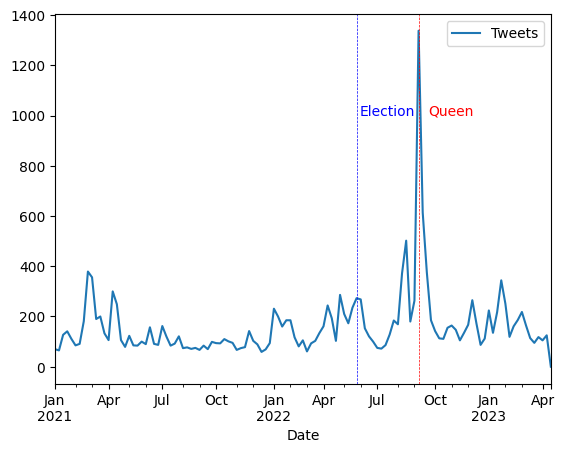

In [ ]:
#timeline plot of tweet volume
tldf=pd.DataFrame.from_dict(tl,orient='index', columns=['Tweets'])
tldf['Date'] = tldf.index
tldf['TweetsN'] = tldf['Tweets']/tldf['Tweets'].mean()
ax = tldf.plot(x='Date', y='Tweets')
ax.axvline(pd.to_datetime('2022-09-08'), color='r', linestyle='--', lw=0.5)
ax.axvline(pd.to_datetime('2022-05-21'), color='b', linestyle='--', lw=0.5)
ax.annotate('Election', xy=(0.58, 0.8), xytext=(12, -12), color='b', va='top', xycoords='axes fraction', textcoords='offset points')
ax.annotate('Queen', xy=(0.72, 0.8), xytext=(12, -12), color='r', va='top', xycoords='axes fraction', textcoords='offset points')

<Axes: xlabel='Date'>

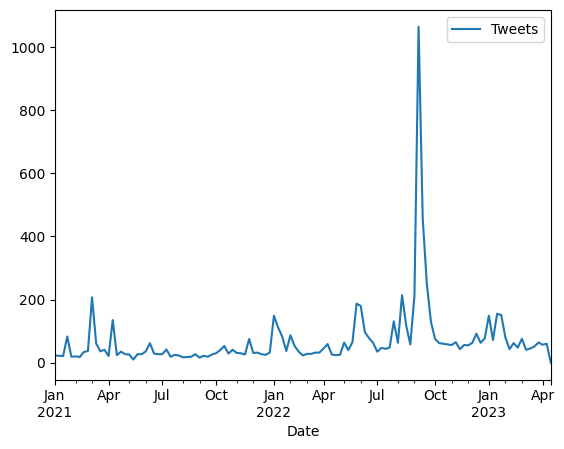

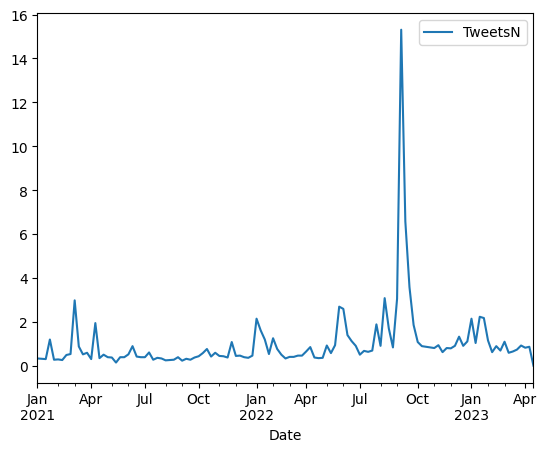

In [ ]:
tldfRelevant=pd.DataFrame.from_dict(tlRelevant,orient='index', columns=['Tweets'])rm
tldfRelevant['Date'] = tldfRelevant.index
tldfRelevant.plot(x='Date', y='Tweets') #queen dies Sept 8 2022, PP april 9 2021 #election may 21 2022
tldfRelevant['TweetsN'] = tldfRelevant['Tweets']/tldfRelevant['Tweets'].mean()
tldfRelevant.plot(x='Date', y='TweetsN')

<Axes: xlabel='Date'>

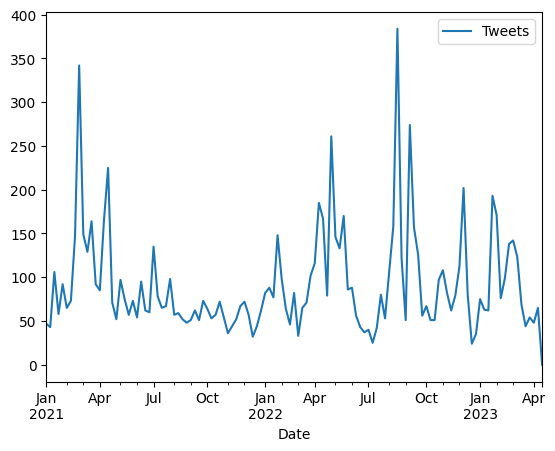

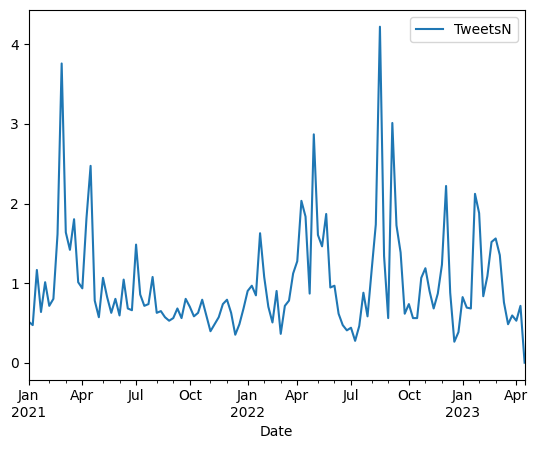

In [ ]:
tldfNotRelevant=pd.DataFrame.from_dict(tlNotRelevant,orient='index', columns=['Tweets'])
tldfNotRelevant['Date'] = tldfNotRelevant.index
tldfNotRelevant.plot(x='Date') #queen dies Sept 8 2022, PP april 9 2021
tldfNotRelevant['TweetsN'] = tldfNotRelevant['Tweets']/tldfNotRelevant['Tweets'].mean()
tldfNotRelevant.plot(x='Date', y='TweetsN')

In [ ]:

tldfSampleRelevant=pd.DataFrame.from_dict(tlSampleRelevant,orient='index', columns=['Tweets'])
tldfSampleRelevant['Date'] = tldfSampleRelevant.index
tldfSampleNotRelevant=pd.DataFrame.from_dict(tlSampleNotRelevant,orient='index', columns=['Tweets'])
tldfSampleNotRelevant['Date'] = tldfSampleNotRelevant.index


In [ ]:
tldfAnti=pd.DataFrame.from_dict(tlAnti,orient='index', columns=['Tweets'])
tldfAnti['Date'] = tldfAnti.index
tldfAnti.plot(x='Date') #queen dies Sept 8 2022, PP april 9 2021
tldfAnti['TweetsN'] = tldfAnti['Tweets']/tldfAnti['Tweets'].mean()
tldfAnti.plot(x='Date', y='TweetsN')

Timeline for Sample data combined

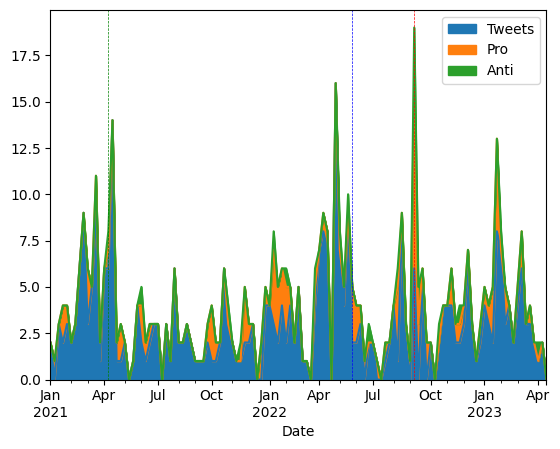

In [ ]:
dfSample = tldfSampleNotRelevant
dfSample['Pro'] = tldfPro['Tweets']
dfSample['Anti'] = tldfAnti['Tweets']

ax = dfSample.plot(x='Date') 
ax.axvline(pd.to_datetime('2022-09-08'), color='r', linestyle='--', lw=0.5)
ax.axvline(pd.to_datetime('2021-04-09'), color='g', linestyle='--', lw=0.5)
ax.axvline(pd.to_datetime('2022-05-21'), color='b', linestyle='--', lw=0.5)

Text(12, -12, 'Queen')

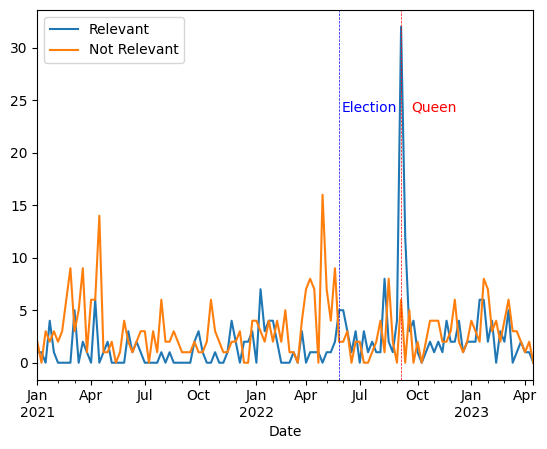

In [ ]:
#Timeline plots of sample data
dfSample = tldfSampleRelevant
dfSample['Not Relevant'] = tldfSampleNotRelevant['Tweets']
dfSample = dfSample.rename(columns={'Tweets': 'Relevant'})
ax = dfSample.plot(x='Date')
ax.axvline(pd.to_datetime('2022-09-08'), color='r', linestyle='--', lw=0.5)
ax.axvline(pd.to_datetime('2022-05-21'), color='b', linestyle='--', lw=0.5)
ax.annotate('Election', xy=(0.58, 0.8), xytext=(12, -12), color='b', va='top', xycoords='axes fraction', textcoords='offset points')
ax.annotate('Queen', xy=(0.72, 0.8), xytext=(12, -12), color='r', va='top', xycoords='axes fraction', textcoords='offset points')